In [155]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os 

import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

from ff_energy.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.structure import atom_key_pairs
from ff_energy.potential import LJ, akp_indx
from ff_energy.ff import FF
from ff_energy.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.data import pairs_data
from ff_energy.utils import pickle_output, read_from_pickle, str2int


from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

from numpyro.infer import Predictive


plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.11.0")




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
_c = next(read_from_pickle("ff_epol_mike_pbe0dz_clusters.pkl"))
_p = next(read_from_pickle("ff_epol_pairs_pbe0dz_pairs.pkl"))
# _c.get_loss_coulomb([1])
_c.data["epol_mike"] = _p.data["epol_mike"].copy()
_c.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,p_m_E_tot,C_ENERGY_kcalmol,NBONDS,nb_intE,n,epol_mike,DUMMY,k,ELEC_comp,epol_pairs
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-958281.958376,-958370.381547,-66.09215,-66.09215,0,-197.910658,0,0,-86.50353,-182.982917
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-958282.584930,-958336.157791,-46.47010,-46.47010,1,-113.959761,0,1,-55.44306,-111.406093
test2,-144.567121,test2,24.75756,-76.78875,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-958285.865743,-958360.493844,-62.36933,-62.36933,2,-160.484782,0,2,-76.78875,-153.110225
test3,-105.558619,test3,21.75948,-60.46748,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-958292.985606,-958352.359334,-54.72007,-54.72007,3,-118.662845,0,3,-60.46748,-111.548989
test4,-141.957058,test4,21.69034,-77.22292,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-958292.418141,-958367.030618,-64.66471,-64.66471,4,-155.773808,0,4,-77.22292,-151.839749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.61850,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-958280.757990,-958357.505436,-66.07558,-66.07558,495,-175.806320,0,495,-83.61850,-166.329665
test496,-126.839243,test496,15.65968,-71.27947,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-958304.589708,-958363.074582,-58.53303,-58.53303,496,-138.410126,0,496,-71.27947,-133.079412
test497,-160.377711,test497,20.65947,-76.28248,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-958294.973787,-958353.280867,-51.51462,-51.51462,497,-178.929213,0,497,-76.28248,-170.886865
test498,-154.210967,test498,21.38907,-73.28759,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-958293.538908,-958358.525003,-52.93080,-52.93080,498,-171.903376,0,498,-73.28759,-164.288222


In [64]:
_p.data["epol_pairs"] = _c.data["epol_pairs"].copy()
_p.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,p_m_E_tot,C_ENERGY_kcalmol,NBONDS,nb_intE,n,epol_mike,DUMMY,k,ELEC_comp,epol_pairs
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-958281.958376,-958370.381547,-66.09215,-66.09215,0,-197.910658,0,0,-86.50353,-182.982917
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-958282.584930,-958336.157791,-46.47010,-46.47010,1,-113.959761,0,1,-55.44306,-111.406093
test2,-144.567121,test2,24.75756,-76.78875,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-958285.865743,-958360.493844,-62.36933,-62.36933,2,-160.484782,0,2,-76.78875,-153.110225
test3,-105.558619,test3,21.75948,-60.46748,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-958292.985606,-958352.359334,-54.72007,-54.72007,3,-118.662845,0,3,-60.46748,-111.548989
test4,-141.957058,test4,21.69034,-77.22292,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-958292.418141,-958367.030618,-64.66471,-64.66471,4,-155.773808,0,4,-77.22292,-151.839749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.61850,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-958280.757990,-958357.505436,-66.07558,-66.07558,495,-175.806320,0,495,-83.61850,-166.329665
test496,-126.839243,test496,15.65968,-71.27947,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-958304.589708,-958363.074582,-58.53303,-58.53303,496,-138.410126,0,496,-71.27947,-133.079412
test497,-160.377711,test497,20.65947,-76.28248,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-958294.973787,-958353.280867,-51.51462,-51.51462,497,-178.929213,0,497,-76.28248,-170.886865
test498,-154.210967,test498,21.38907,-73.28759,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-958293.538908,-958358.525003,-52.93080,-52.93080,498,-171.903376,0,498,-73.28759,-164.288222


In [65]:
print(_p)
print(_c)

FF: LJ water_cluster epol_pairs Exact P_intE (jax_coloumb: True)
FF: LJ water_cluster epol_mike Exact intE (jax_coloumb: True)


In [80]:
fit_repeat(_c, 
           5, 
           None,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ff_fit.py:173: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


In [81]:
pd.DataFrame(_c.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
3,16.578283,1290,2176,0,True,Optimization terminated successfully.,"[0.8327502161842641, 2.49997967856505, 0.00010...","([[0.8327502161842641, 2.49997967856505, 0.000..."
9,16.578310,616,1067,0,True,Optimization terminated successfully.,"[0.8318734936650632, 2.499975583328236, 0.0001...","([[0.8318734936650632, 2.499975583328236, 0.00..."
6,17.169668,434,779,0,True,Optimization terminated successfully.,"[0.25269149857272116, 2.3149151461221056, 0.01...","([[0.25269149857272116, 2.3149151461221056, 0...."
5,18.716429,433,779,0,True,Optimization terminated successfully.,"[0.44089607783661816, 2.0804779439099654, 0.00...","([[0.44089607783661816, 2.0804779439099654, 0...."
8,49.495144,321,594,0,True,Optimization terminated successfully.,"[0.25, 2.0873681381799205, 0.5, 0.039411365998...","([[0.25, 2.0873681381799205, 0.5, 0.0394113659..."
2,49.495159,216,415,0,True,Optimization terminated successfully.,"[0.25, 2.0873546079679812, 0.5, 0.039413984889...","([[0.25, 2.0873546079679812, 0.5, 0.0394139848..."
10,76.328255,299,529,0,True,Optimization terminated successfully.,"[0.9153041408408054, 1.7972038897933427, 0.000...","([[0.9153041408408054, 1.7972038897933427, 0.0..."
0,129.745026,47,74,0,True,Optimization terminated successfully.,"[0.25, 0.25, 0.00010000000000000003, 0.0001]","([[0.25, 0.25, 0.00010000000000000003, 0.0001]..."
1,365.456390,133,264,0,True,Optimization terminated successfully.,"[1.3985521718522658, 1.1892853577187217, 0.026...","([[1.3985521718522658, 1.1892853577187217, 0.0..."
4,8202.435547,84,192,0,True,Optimization terminated successfully.,"[0.25, 0.252542174516303, 0.000100000000000000...","([[0.25, 0.252542174516303, 0.0001000000000000..."


In [68]:
TARGETS = _c.targets

In [69]:
FIT = _c.eval_jax(_c.get_best_parm())

In [87]:
_c.data["TARGET"] = TARGETS
_c.data["FIT"] = FIT
_c.data["RESIDUALS"] = TARGETS - FIT
_c.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,n,epol_mike,DUMMY,k,ELEC_comp,epol_pairs,TARGET,FIT,manybody_diff,RESIDUALS
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,0,-197.910658,0,0,-86.50353,-182.982917,108.232925,102.468155,14.927741,5.764771
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,1,-113.959761,0,1,-55.44306,-111.406093,59.838684,61.077240,2.553668,-1.238556
test2,-144.567121,test2,24.75756,-76.78875,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,2,-160.484782,0,2,-76.78875,-153.110225,85.515778,81.842102,7.374557,3.673676
test3,-105.558619,test3,21.75948,-60.46748,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,3,-118.662845,0,3,-60.46748,-111.548989,58.322525,61.654243,7.113856,-3.331718
test4,-141.957058,test4,21.69034,-77.22292,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,4,-155.773808,0,4,-77.22292,-151.839749,80.150795,77.226318,3.934060,2.924477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.61850,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,495,-175.806320,0,495,-83.61850,-166.329665,96.879715,94.190712,9.476656,2.689003
test496,-126.839243,test496,15.65968,-71.27947,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,496,-138.410126,0,496,-71.27947,-133.079412,78.393387,81.909454,5.330714,-3.516068
test497,-160.377711,test497,20.65947,-76.28248,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,497,-178.929213,0,497,-76.28248,-170.886865,119.405151,117.371803,8.042348,2.033348
test498,-154.210967,test498,21.38907,-73.28759,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,498,-171.903376,0,498,-73.28759,-164.288222,104.633644,109.056015,7.615154,-4.422371


In [102]:
residuals_hpdi = hpdi(_c.data["RESIDUALS"])
residuals_hpdi
error = residuals_hpdi[1] - _c.data["RESIDUALS"].mean()
error

6.679838

In [192]:
_c.data["manybody_diff"] = (_c.data["epol_mike"] - _c.data["epol_pairs"] ).abs() 
_c.data[["intE", "manybody_diff", "epol_mike", "TARGET"]]

,intE,manybody_diff,epol_mike,TARGET
test0,-89.677734,14.927741,-197.910658,108.232925
test1,-54.121080,2.553668,-113.959761,59.838684
test2,-74.969007,7.374557,-160.484782,85.515778
test3,-60.340318,7.113856,-118.662845,58.322525
test4,-75.623009,3.934060,-155.773808,80.150795
...,...,...,...,...
test495,-78.926606,9.476656,-175.806320,96.879715
test496,-60.016740,5.330714,-138.410126,78.393387
test497,-59.524062,8.042348,-178.929213,119.405151
test498,-67.269733,7.615154,-171.903376,104.633644


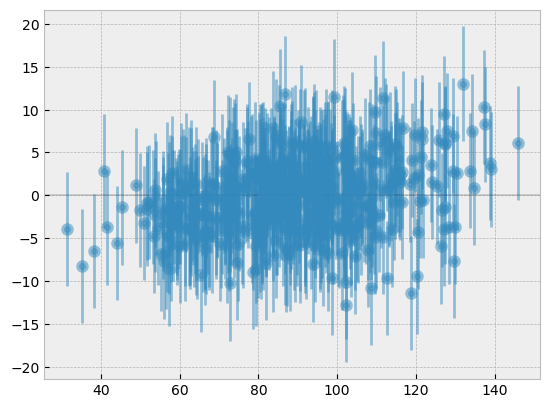

In [123]:
plt.errorbar(_c.data["TARGET"], _c.data["RESIDUALS"], yerr=error, marker="o", ms=5, mew=4, ls="none", alpha=0.5)
plt.axhline(0, c="k", linewidth=0.2)

Text(0, 0.5, 'Pairs - Cluster polarization [kcal/mol]')

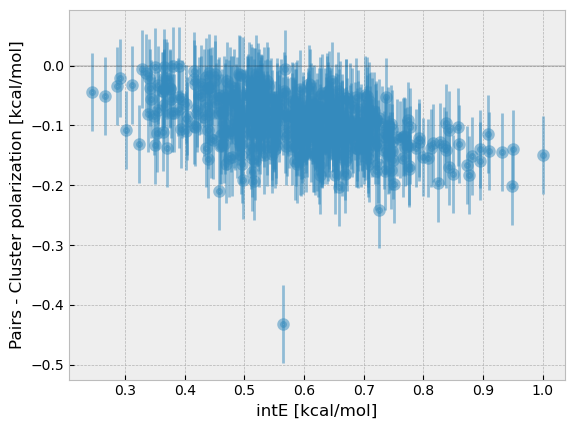

In [130]:
plt.errorbar(_c.data["intE"]/_c.data["intE"].min(), _c.data["manybody_diff"], yerr=-error/_c.data["intE"].min(), marker="o", ms=5, mew=4, ls="none", alpha=0.5)
plt.axhline(0, c="k", linewidth=0.2)
plt.xlabel("intE [kcal/mol]")
plt.ylabel("Pairs - Cluster polarization [kcal/mol]")

(-0.2, 0.0)

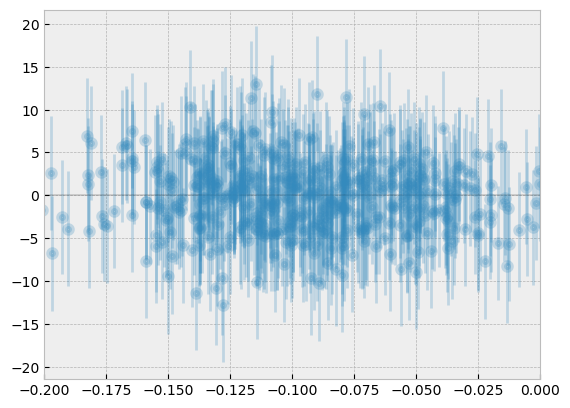

In [128]:
plt.errorbar(_c.data["manybody_diff"], _c.data["RESIDUALS"], yerr=error, marker="o", ms=5, mew=4, ls="none", alpha=0.25)
plt.axhline(0, c="k", linewidth=0.2)
plt.xlim(-0.2, 0)

(array([  5.,  14.,  52.,  82.,  94., 101.,  69.,  50.,  21.,  12.]),
 array([ 35.25759506,  45.70623398,  56.15486908,  66.603508  ,
         77.05214691,  87.50078583,  97.94942474, 108.39805603,
        118.84669495, 129.29533386, 139.74397278]),
 <BarContainer object of 10 artists>)

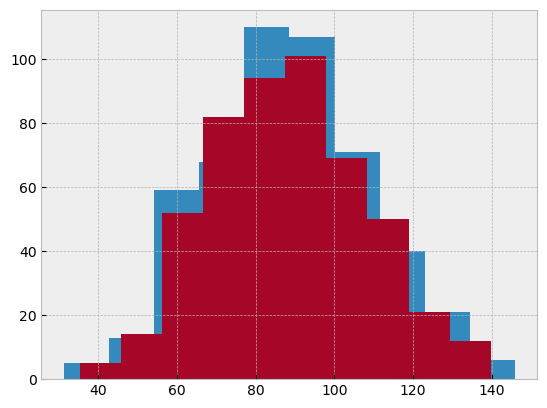

In [86]:
# plt.scatter(TARGETS, FIT)
plt.hist(TARGETS)
plt.hist(FIT)
# plt.hist(_p.targets)

(array([  4.,  14.,  32.,  93., 109., 131.,  70.,  37.,   6.,   4.]),
 array([-12.82927704, -10.24116421,  -7.65305185,  -5.06493902,
         -2.47682643,   0.11128616,   2.69939876,   5.28751135,
          7.87562418,  10.46373653,  13.05184937]),
 <BarContainer object of 10 artists>)

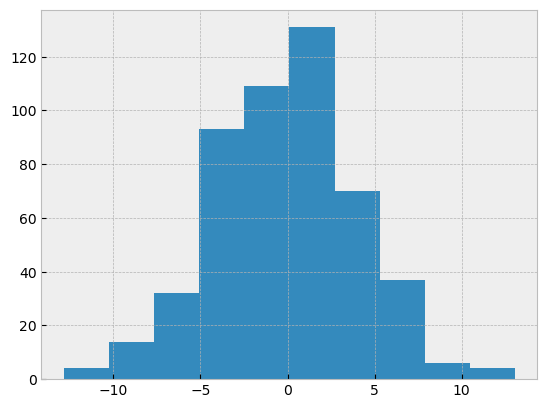

In [121]:
plt.hist(_c.data["RESIDUALS"])

In [117]:
_c.data.sort_values("manybody_diff")

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,n,epol_mike,DUMMY,k,ELEC_comp,epol_pairs,TARGET,FIT,manybody_diff,RESIDUALS
test64,-96.379379,test64,21.27887,-43.80482,10.23596,test64,-1527.154680,test64,20,-1527.218444,...,64,-104.133371,0,64,-43.80482,-104.125211,64.120758,62.821491,0.008160,1.299267
test340,-73.217959,test340,26.24033,-37.96203,1.35009,test340,-1527.136802,test340,20,-1527.198835,...,340,-79.777397,0,340,-37.96203,-79.751377,40.851521,38.037231,0.026020,2.814289
test268,-80.155266,test268,22.23684,-36.50655,6.03579,test268,-1527.152102,test268,20,-1527.209227,...,268,-87.494176,0,268,-36.50655,-87.439766,51.648018,52.566235,0.054410,-0.918217
test40,-90.359303,test40,24.53076,-46.89620,9.79755,test40,-1527.143692,test40,20,-1527.203482,...,40,-96.719622,0,40,-46.89620,-96.603311,59.201340,62.945808,0.116310,-3.744469
test227,-91.153701,test227,21.15110,-40.23696,11.03014,test227,-1527.155711,test227,20,-1527.209344,...,227,-96.415956,0,227,-40.23696,-96.590739,62.761356,65.544945,0.174783,-2.783588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test136,-176.221893,test136,24.17935,-89.23696,24.92551,test136,-1527.133709,test136,20,-1527.276970,...,136,-203.525851,0,136,-89.23696,-187.118815,113.629318,112.269958,16.407036,1.359360
test234,-154.626939,test234,27.77727,-82.23405,22.13711,test234,-1527.118984,test234,20,-1527.253855,...,234,-182.226031,0,234,-82.23405,-165.571475,97.593994,104.391998,16.654556,-6.798004
test436,-173.535337,test436,24.44670,-93.00877,28.26309,test436,-1527.131575,test436,20,-1527.250194,...,436,-201.759741,0,436,-93.00877,-183.856139,127.325806,128.688736,17.903602,-1.362930
test344,-194.461600,test344,19.70607,-100.59878,27.65448,test344,-1527.151258,test344,20,-1527.306525,...,344,-224.082843,0,344,-100.59878,-204.527923,126.652740,128.349640,19.554921,-1.696899


In [193]:
_c.data[["TARGET", "FIT", "manybody_diff"]]

,TARGET,FIT,manybody_diff
test0,108.232925,102.468155,14.927741
test1,59.838684,61.077240,2.553668
test2,85.515778,81.842102,7.374557
test3,58.322525,61.654243,7.113856
test4,80.150795,77.226318,3.934060
...,...,...,...
test495,96.879715,94.190712,9.476656
test496,78.393387,81.909454,5.330714
test497,119.405151,117.371803,8.042348
test498,104.633644,109.056015,7.615154


In [322]:
standardize = lambda x: (x - x.mean()) / x.std()

_c.data["TARGETScaled"] = _c.data.TARGET.pipe(standardize)
_c.data["FITScaled"] = _c.data.FIT.pipe(standardize)
_c.data['manybody_diff_S'] = _c.data['manybody_diff'] / _c.data['epol_mike'].std() 

In [323]:
_c.data[["TARGETScaled", "FITScaled", "manybody_diff_S"]]

,TARGETScaled,FITScaled,manybody_diff_S
test0,0.977871,0.723017,0.516475
test1,-1.388222,-1.394852,0.088353
test2,-0.132816,-0.332366,0.255147
test3,-1.462350,-1.365328,0.246128
test4,-0.395121,-0.568544,0.136112
...,...,...,...
test495,0.422790,0.299481,0.327876
test496,-0.481045,-0.328920,0.184434
test497,1.524104,1.485599,0.278252
test498,0.801895,1.060101,0.263472


In [324]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [325]:
def model(fit, targets, targets_sd):
    #  std
    sigma = numpyro.sample("sigma", 
                           dist.Exponential(1.0))
    
    #  sample the scale factor
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    
    #  computer the mean
    mu = fit * a 
    #  assume a distribution for the fit
    fit_dist = numpyro.sample("fit_dist", 
                              dist.Normal(mu, sigma))
    #  compare to targets
    numpyro.sample("obs", 
                   dist.Normal(fit_dist, targets_sd), 
                   obs=targets)



In [326]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(
    rng_key_,
    fit = _c.data["FITScaled"].values,
    targets = _c.data["TARGETScaled"].values,
    targets_sd = _c.data['manybody_diff_S'].abs().values
)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 702.74it/s, 63 steps of size 8.76e-02. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            a      0.99      0.01      0.99      0.97      1.01   2609.37      1.00
  fit_dist[0]      0.73      0.13      0.73      0.51      0.96   8989.14      1.00
  fit_dist[1]     -1.39      0.08     -1.38     -1.51     -1.27   7806.61      1.00
  fit_dist[2]     -0.29      0.12     -0.29     -0.50     -0.09   8999.04      1.00
  fit_dist[3]     -1.37      0.12     -1.38     -1.56     -1.19   7525.90      1.00
  fit_dist[4]     -0.48      0.10     -0.48     -0.65     -0.33   8193.17      1.00
  fit_dist[5]     -0.27      0.12     -0.27     -0.46     -0.04   7799.94      1.00
  fit_dist[6]      0.95      0.10      0.95      0.79      1.10   8678.52      1.00
  fit_dist[7]      0.19      0.10      0.19      0.02      0.34   7956.80      1.00
  fit_dist[8]     -0.51      0.06     -0.51     -0.60     -0.41   8345.13      1.00
  fit_dist[9]      0.33      0.11      0.33      0.13      0.50   7853.10  

In [327]:
samples["fit_dist"].shape

(3000, 500)

In [328]:
rng_key, rng_key_ = random.split(rng_key)
predictions_4 = Predictive(model, samples)(
    rng_key_,
    fit = _c.data["FITScaled"].values,
    targets = _c.data["TARGETScaled"].values,
    targets_sd = _c.data['manybody_diff_S'].abs().values
)

In [329]:
# predictions_4["obs"]

In [330]:
samples

{'a': Array([0.9754231 , 0.99071586, 0.98239714, ..., 0.9908445 , 0.97699153,
        0.9785612 ], dtype=float32),
 'fit_dist': Array([[ 0.7887029 , -1.2699337 , -0.25816673, ...,  1.3190087 ,
          1.2661899 ,  0.80303425],
        [ 0.6726468 , -1.4945208 , -0.3231821 , ...,  1.5441828 ,
          0.7433947 ,  1.0231508 ],
        [ 0.78095245, -1.3207303 , -0.3437649 , ...,  1.4702967 ,
          1.0056138 ,  0.9391874 ],
        ...,
        [ 0.664316  , -1.522826  , -0.28671676, ...,  1.5064594 ,
          1.0157055 ,  0.710643  ],
        [ 0.8107983 , -1.2699263 , -0.2301208 , ...,  1.4371606 ,
          0.9609504 ,  1.1594169 ],
        [ 0.8583977 , -1.17085   , -0.02405062, ...,  1.5338444 ,
          1.0063438 ,  0.8788191 ]], dtype=float32),
 'sigma': Array([0.13891414, 0.13792942, 0.13603158, ..., 0.13464092, 0.13525707,
        0.13339278], dtype=float32)}

In [331]:
# residuals_mean

In [332]:
_c.data["TARGETScaled"]

test0      0.977871
test1     -1.388222
test2     -0.132816
test3     -1.462350
test4     -0.395121
             ...   
test495    0.422790
test496   -0.481045
test497    1.524104
test498    0.801895
test499    0.752430
Name: TARGETScaled, Length: 500, dtype: float32

err [0.21897344 0.12955771 0.20949817 0.19017857 0.16636083 0.19207422
 0.16272104 0.1655738  0.09260575 0.20054446 0.09678666 0.18055359
 0.20952854 0.21247216 0.22619313 0.18011364 0.19573101 0.21472558
 0.19323719 0.19854535 0.19937631 0.18052928 0.17760289 0.19417581
 0.15919746 0.20411207 0.09143875 0.06909105 0.06343    0.10702144
 0.16284192 0.17255874 0.17765725 0.19189234 0.15158539 0.1617057
 0.18464002 0.19459814 0.13735399 0.11029749 0.00676826 0.17467603
 0.16320677 0.19017166 0.05046313 0.0853375  0.05623803 0.06983393
 0.20153056 0.2149342  0.18683675 0.18447182 0.19831765 0.17823315
 0.18075366 0.1871446  0.18187062 0.17734616 0.21484016 0.20014869
 0.23897924 0.22113585 0.18317977 0.17603219 0.00046893 0.20856574
 0.18784729 0.16419742 0.19434473 0.17749196 0.11850386 0.20226893
 0.04325575 0.07351545 0.1065945  0.17132948 0.07231339 0.14848226
 0.22096682 0.19328211 0.21601613 0.11473974 0.06780384 0.18837342
 0.19642425 0.17717658 0.17817363 0.18805426 0.18649986 0.0

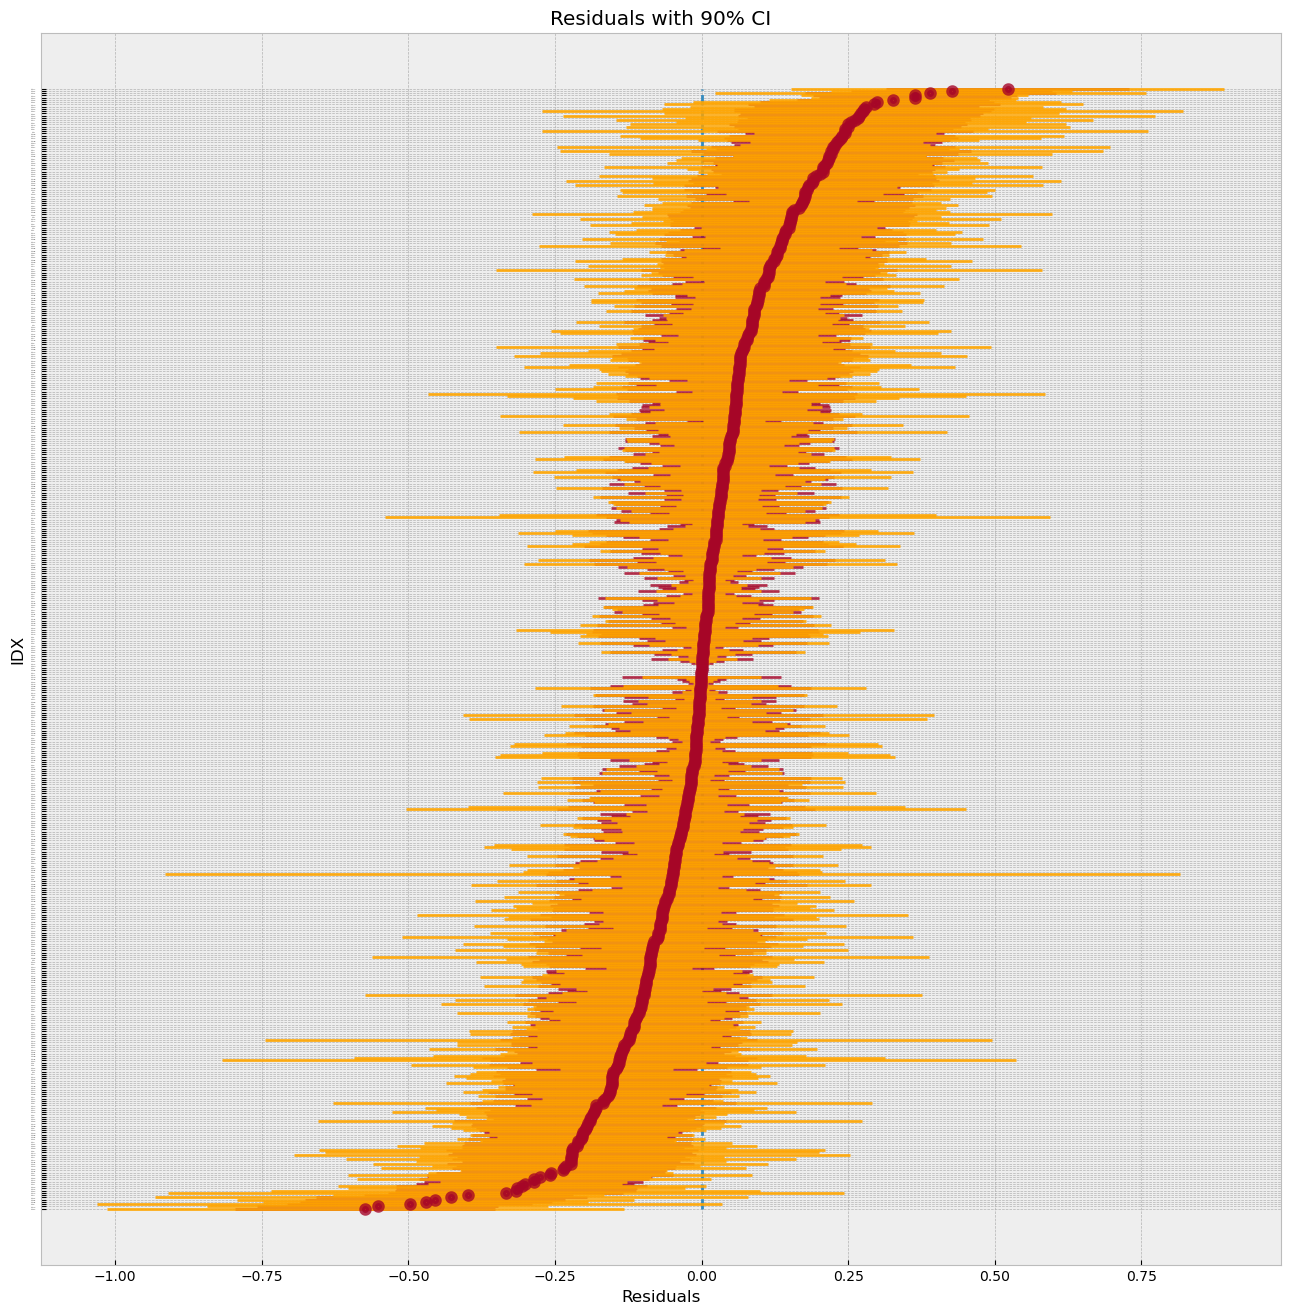

In [333]:
dset = _c.data

sd = dset.manybody_diff_S.abs().values
residuals_4 = dset.TARGETScaled.values - samples["fit_dist"]
residuals_mean = jnp.mean(residuals_4, axis=0)
residuals_hpdi = hpdi(residuals_4, 0.9)
err = abs(residuals_hpdi[1] - residuals_mean)

print("err", err)

idx = jnp.argsort(residuals_mean)
y = jnp.arange(500)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))


# Plot Residuals
ax.plot(jnp.zeros(500), y, "--")
ax.errorbar(
    residuals_mean[idx], y, xerr=err[idx], marker="o", ms=5, mew=4, ls="none", alpha=0.8
)

# Plot SD
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx], ls="none", color="orange", alpha=0.9)


ax.set(xlabel="Residuals", ylabel="IDX", title="Residuals with 90% CI")

ax.set_yticks(ticks = y)

ax.set_yticklabels(np.array(dset.index)[idx], fontsize=1)

plt.show()

# ax.text(
#     -2.8,
#     -7,
#     "Residuals (with error-bars) from current model (in red). "
#     "Black marker \nshows residuals from the previous model (Model 3). "
#     "Measurement \nerror is indicated by orange bar.",
# );

0.0


(<Axes: xlabel='Target', ylabel='Fit'>,
 {'MSE': 16.578283,
  'RMSE': 4.071644,
  'R': 0.9802704158089331,
  'RS': 0.9805193140772561,
  'n': 500,
  'slope': 0.936677207603396,
  'intercept': 5.69256909441809})

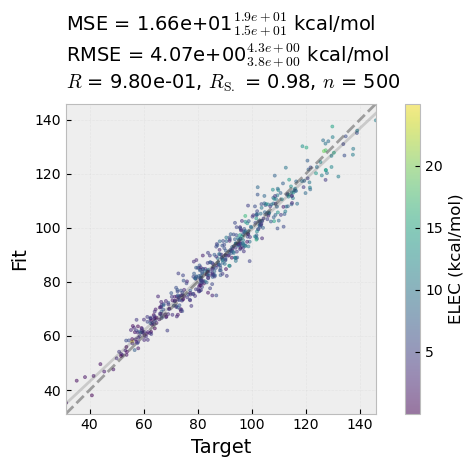

In [334]:
plot_energy_MSE(_c.data, "TARGET", "FIT", elec="manybody_diff", xlabel="Target", ylabel="Fit",s=5)